In [1]:
import os
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bambi as bmb
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "logistic"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


In [3]:
raw_df = pd.read_excel(
    "https://doi.org/10.1371/journal.pmed.1002479.s001", sheet_name="data"
)


In [4]:
raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   anon_id      2063 non-null   int64  
 1   group        2063 non-null   object 
 2   imd_decile   2063 non-null   int64  
 3   partners     2063 non-null   object 
 4   gender       2063 non-null   object 
 5   msm          2063 non-null   object 
 6   ethnicgrp    2063 non-null   object 
 7   age          2063 non-null   int64  
 8   anytest_sr   1880 non-null   float64
 9   anydiag_sr   1880 non-null   float64
 10  anytreat_sr  1875 non-null   float64
 11  anytest      1739 non-null   float64
 12  anydiag      1739 non-null   float64
 13  anytreat     1730 non-null   float64
 14  time_test    1739 non-null   float64
 15  time_treat   1730 non-null   float64
 16  sh24_launch  2063 non-null   object 
dtypes: float64(8), int64(3), object(6)
memory usage: 274.1+ KB


In [5]:
raw_df.groupby("group", as_index=False).agg({"anytest": ["mean", "std", "count"]})

group   anytest                
                mean       std count
0  Control  0.211491  0.408616   818
1    SH:24  0.476656  0.499726   921

In [34]:
df = (
    raw_df.copy()
    .filter(items=["anytest", "group"])
    .dropna(axis=0)
    .assign(tx=lambda x: x["group"].map({"Control": 0, "SH:24": 1}))
    .drop(columns="group")
)

In [49]:
logistic_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1.25),
    "tx": bmb.Prior("Normal", mu=0, sigma=1),
}
logistic_model = bmb.Model(
    formula="anytest ~ tx",
    data=df,
    family="bernoulli",
    link="logit",
    priors=logistic_model_priors,
)
logistic_model


       Formula: anytest ~ tx
        Family: bernoulli
          Link: p = logit
  Observations: 1739
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.25)
            tx ~ Normal(mu: 0.0, sigma: 1.0)

In [50]:
logistic_model.build()

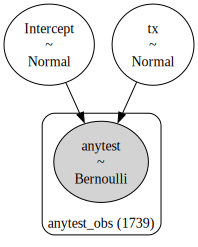

In [51]:
logistic_model.graph()

Sampling: [Intercept, tx]


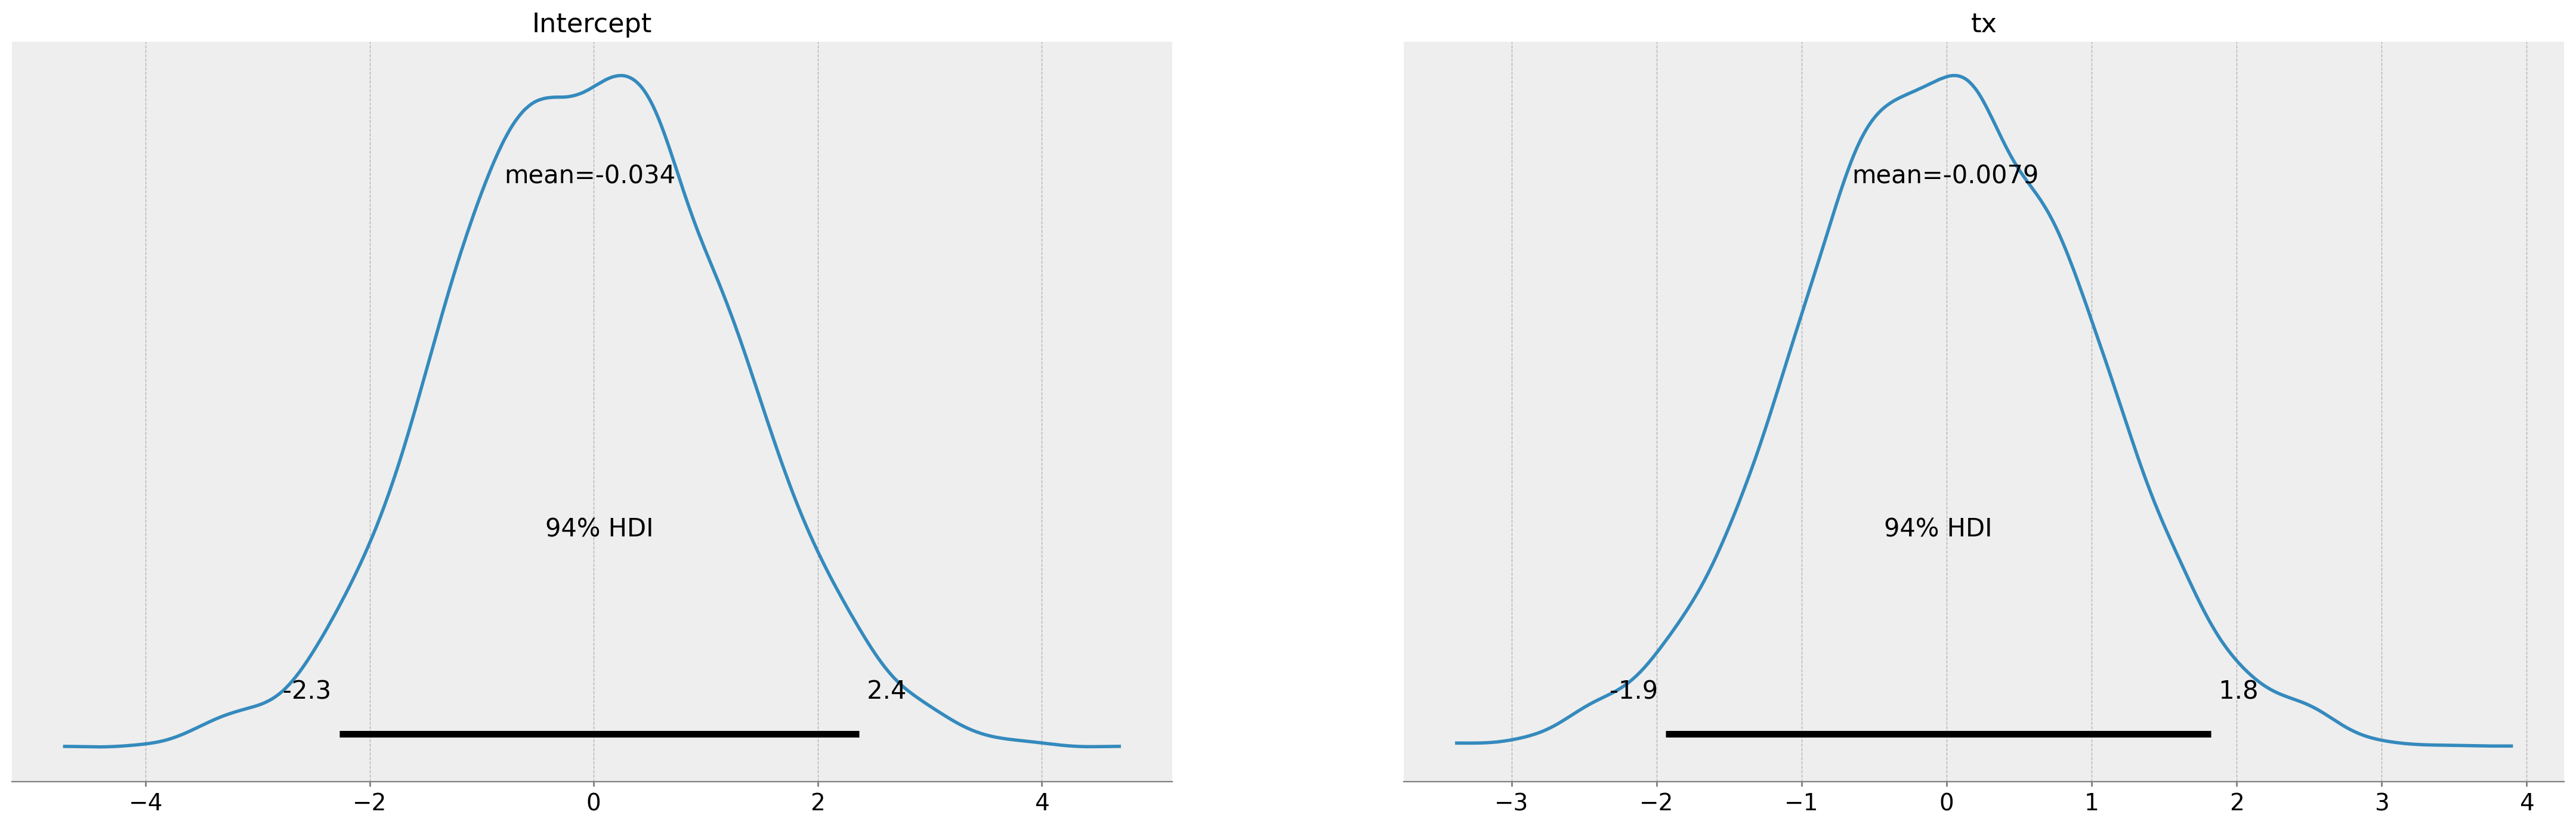

In [52]:
axes = logistic_model.plot_priors(random_seed=rng)

<AxesSubplot:ylabel='Density'>

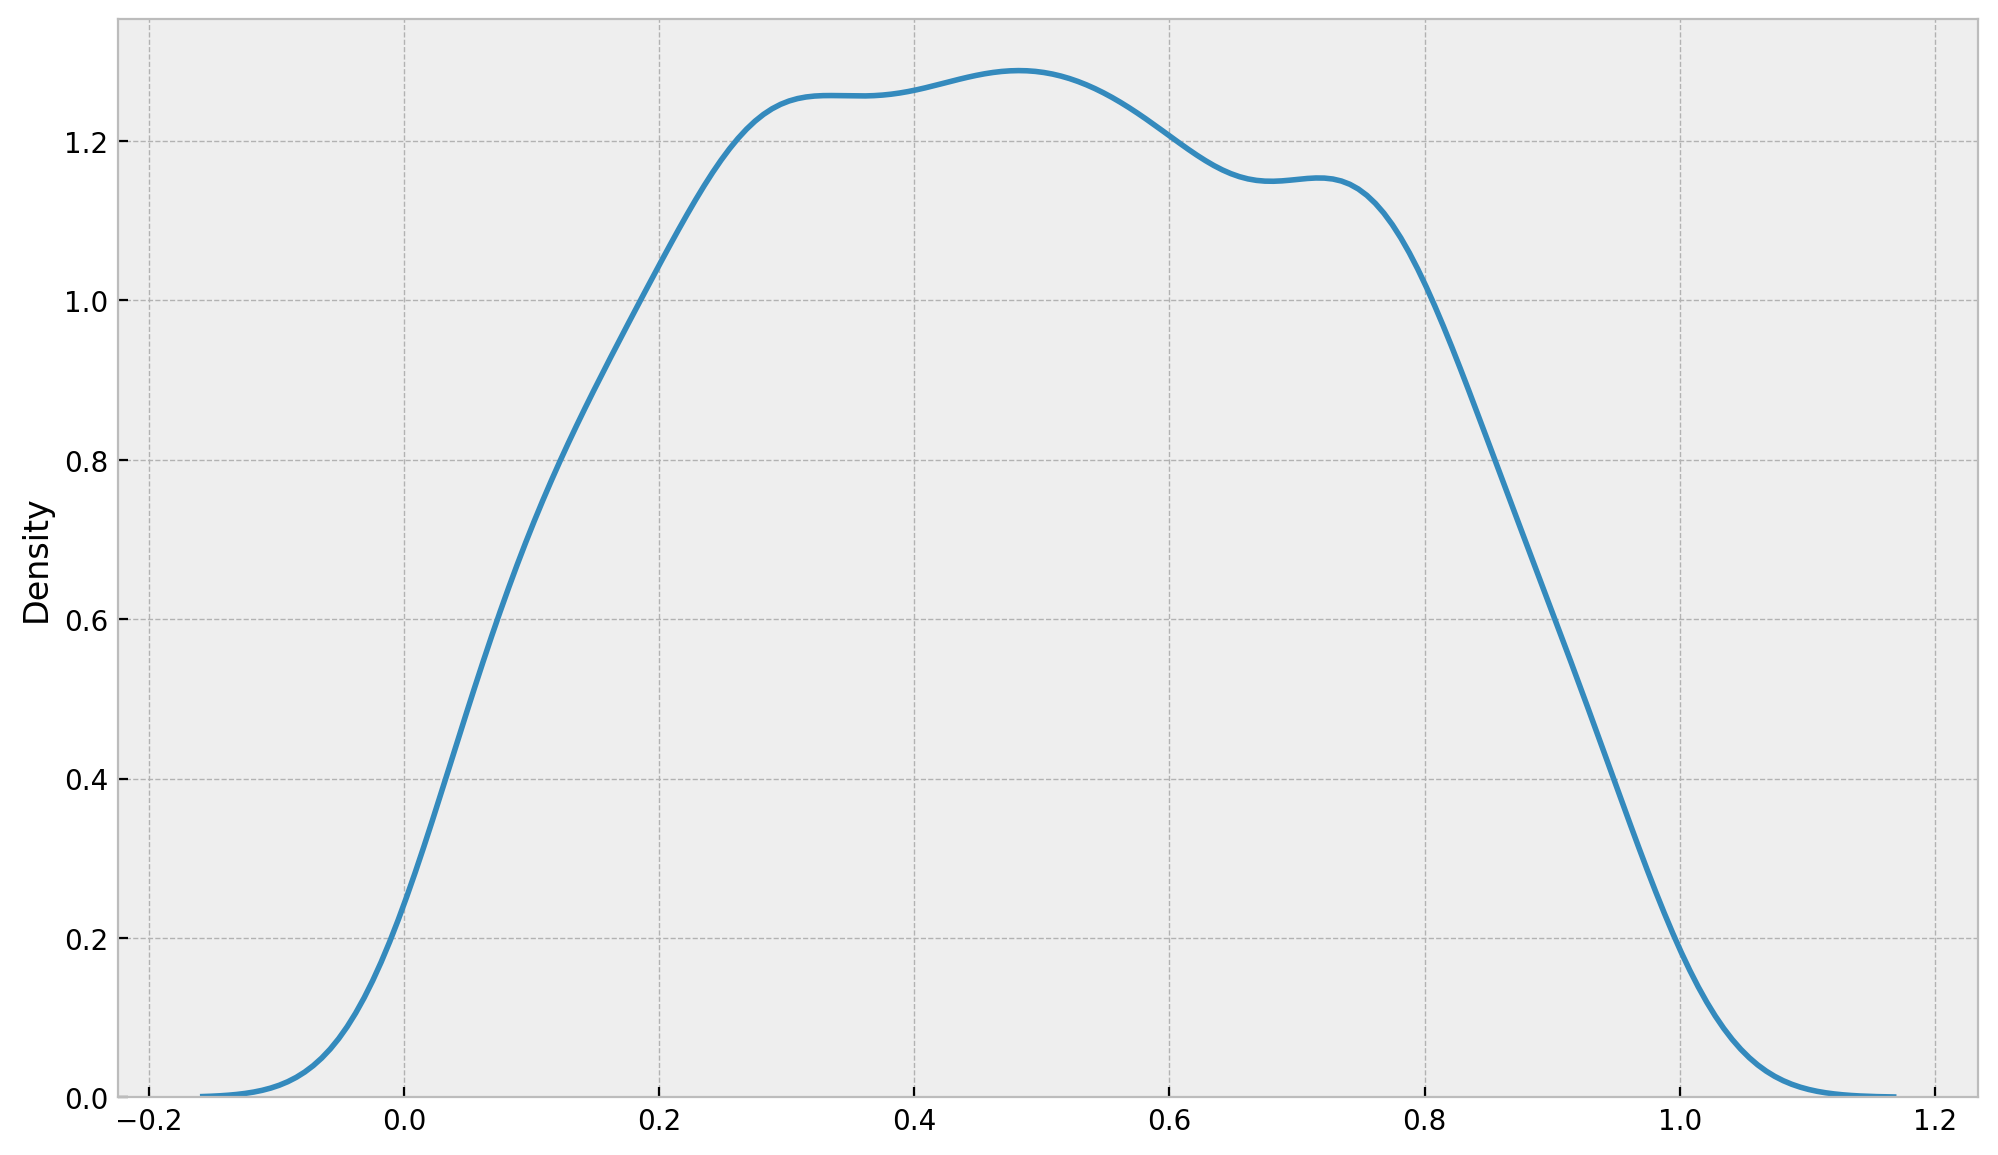

In [95]:
import pymc as pm

sns.kdeplot(expit(pm.draw(vars=pm.Normal.dist(mu=0, sigma=1.25), draws=1_000)))

In [53]:
logistic_idata = logistic_model.fit(
    draws=2_000, nuts_sampler="numpyro", random_seed=rng
)


Modeling the probability that anytest==1
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.163376
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:04.123658
Transforming variables...
Transformation time =  0:00:00.008067


In [54]:
az.summary(data=logistic_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.308,0.084,-1.460,-1.147,0.001,0.001,4623.0,4974.0,1.0
tx,1.210,0.107,1.021,1.418,0.001,0.001,5089.0,5170.0,1.0


<AxesSubplot:title={'center':'ATE'}>

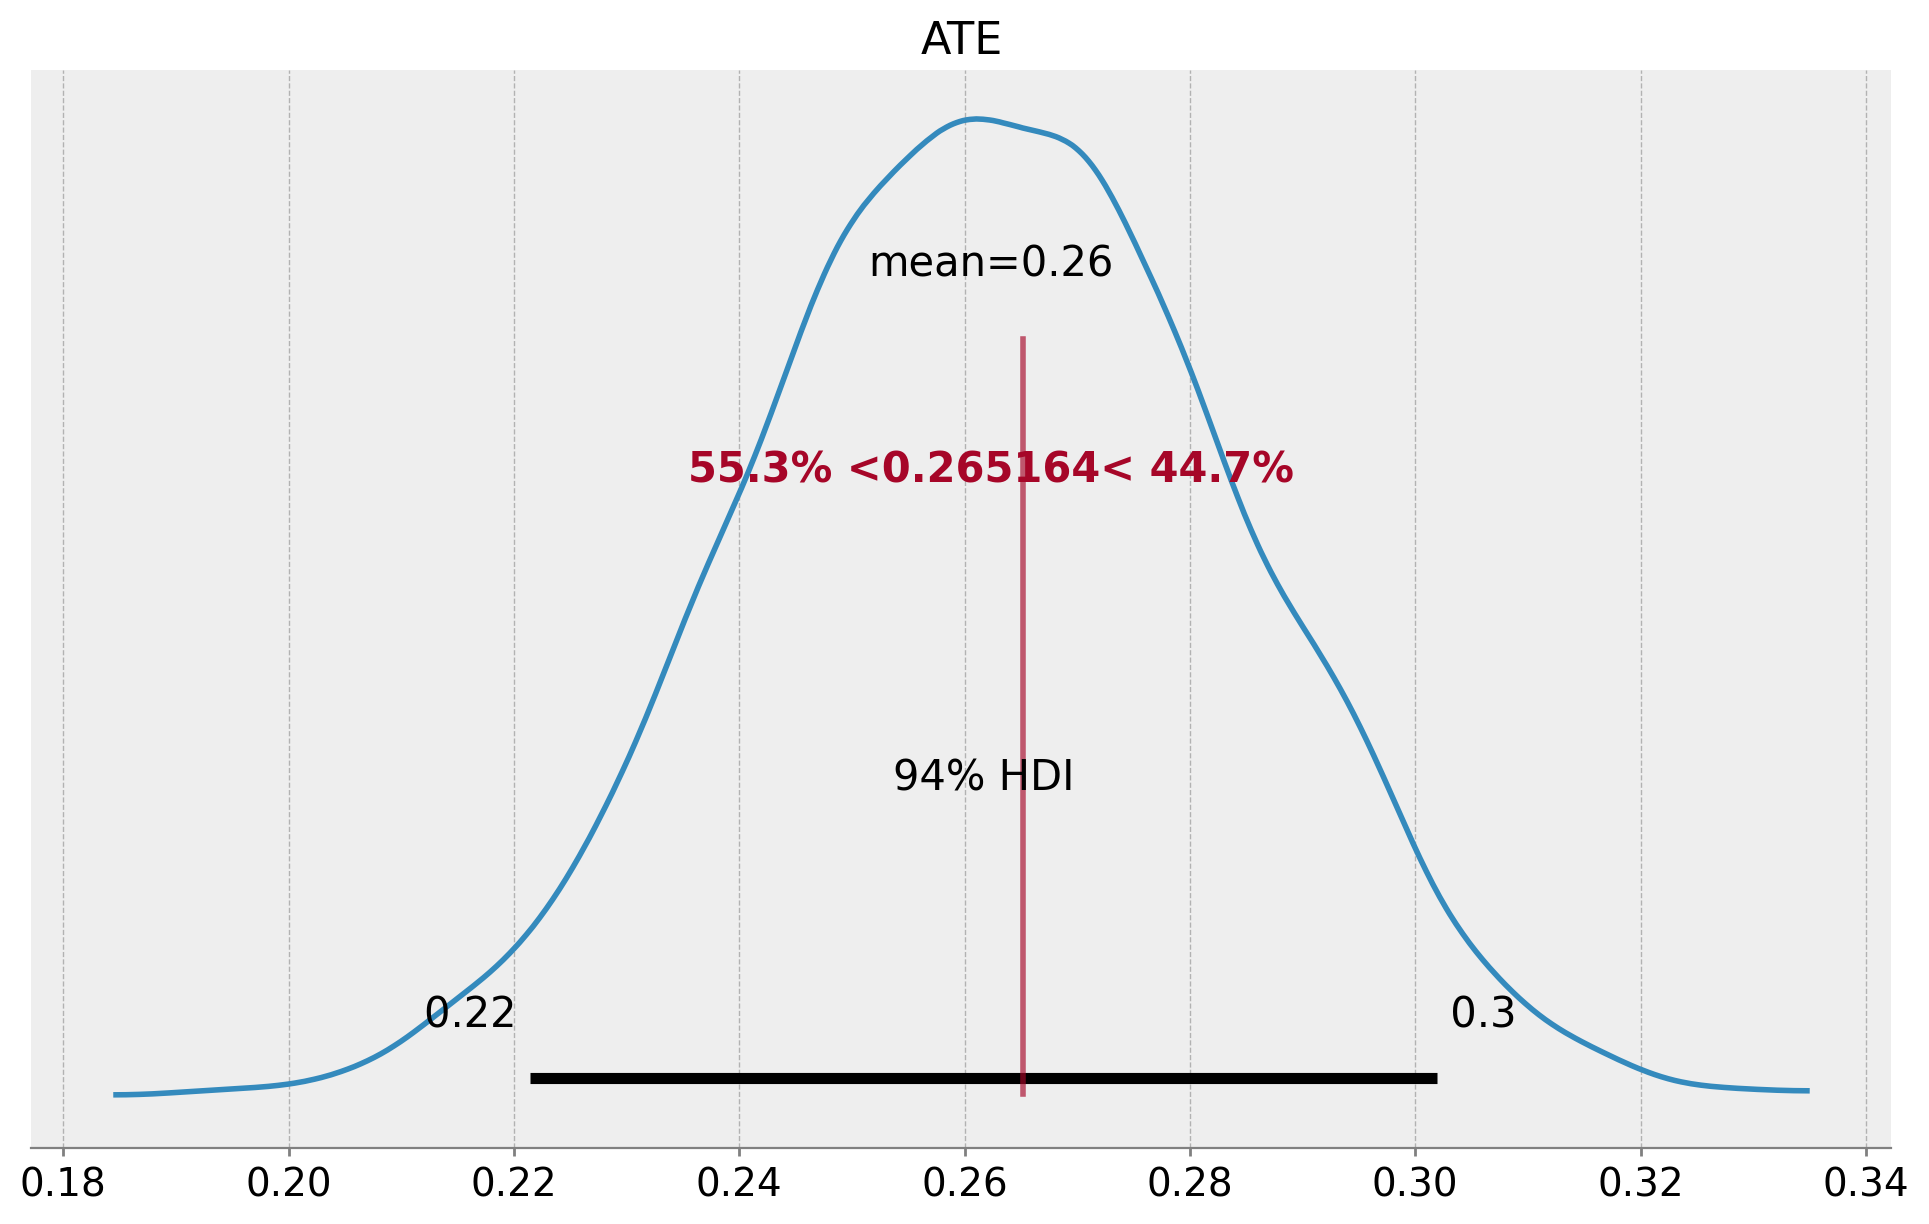

In [65]:
from scipy.special import expit, logit

ate_samples = expit(
    logistic_idata["posterior"]["Intercept"] + logistic_idata["posterior"]["tx"]
) - expit(logistic_idata["posterior"]["Intercept"])

ate_samples.name = "ATE"

diff_means = (
    df.query("tx == 1")["anytest"].mean() - df.query("tx == 0")["anytest"].mean()
)

az.plot_posterior(data=ate_samples, ref_val=diff_means)


In [42]:
df.query("tx == 1")["anytest"].mean() - df.query("tx == 0")["anytest"].mean()

0.2651643663605786

In [44]:
import statsmodels.formula.api as smf

smf.ols("anytest ~ tx", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                anytest   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     144.5
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           4.96e-32
Time:                        11:53:07   Log-Likelihood:                -1112.9
No. Observations:                1739   AIC:                             2230.
Df Residuals:                    1737   BIC:                             2241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2115      0.016     13.174      0.000       0.180       0.243
tx             0.2652      0.022     12.021      0.000       0.222       0.308
==============================================================================
Omnibus:                    38241.926   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.327
Skew:                           0.532   Prob(JB):                     6.43e-48
Kurtosis:                       1.634   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
gaussian_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2),
    "tx": bmb.Prior("Normal", mu=0, sigma=2),
    "sigma": bmb.Prior("HalfCauchy", beta=1),
}
gaussian_model = bmb.Model(
    formula="anytest ~ tx",
    data=df,
    family="gaussian",
    link="identity",
    priors=gaussian_model_priors,
)
gaussian_model


       Formula: anytest ~ tx
        Family: gaussian
          Link: mu = identity
  Observations: 1739
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.0)
            tx ~ Normal(mu: 0.0, sigma: 2.0)
        
        Auxiliary parameters
            anytest_sigma ~ HalfCauchy(beta: 1.0)

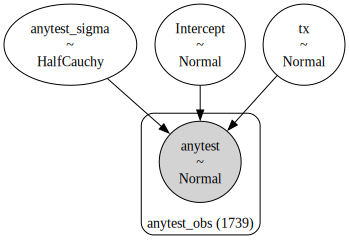

In [70]:
gaussian_model.build()
gaussian_model.graph()


In [74]:
gaussian_idata = gaussian_model.fit(
    draws=2_000, nuts_sampler="numpyro", random_seed=rng
)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.270750
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:04.365400
Transforming variables...
Transformation time =  0:00:00.027599


In [75]:
az.summary(data=gaussian_idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.211,0.016,0.181,0.241,0.0,0.0,8542.0,6130.0,1.0
tx,0.265,0.022,0.223,0.305,0.0,0.0,8044.0,5866.0,1.0
anytest_sigma,0.459,0.008,0.445,0.474,0.0,0.0,8631.0,6097.0,1.0


<AxesSubplot:title={'center':'ATE'}>

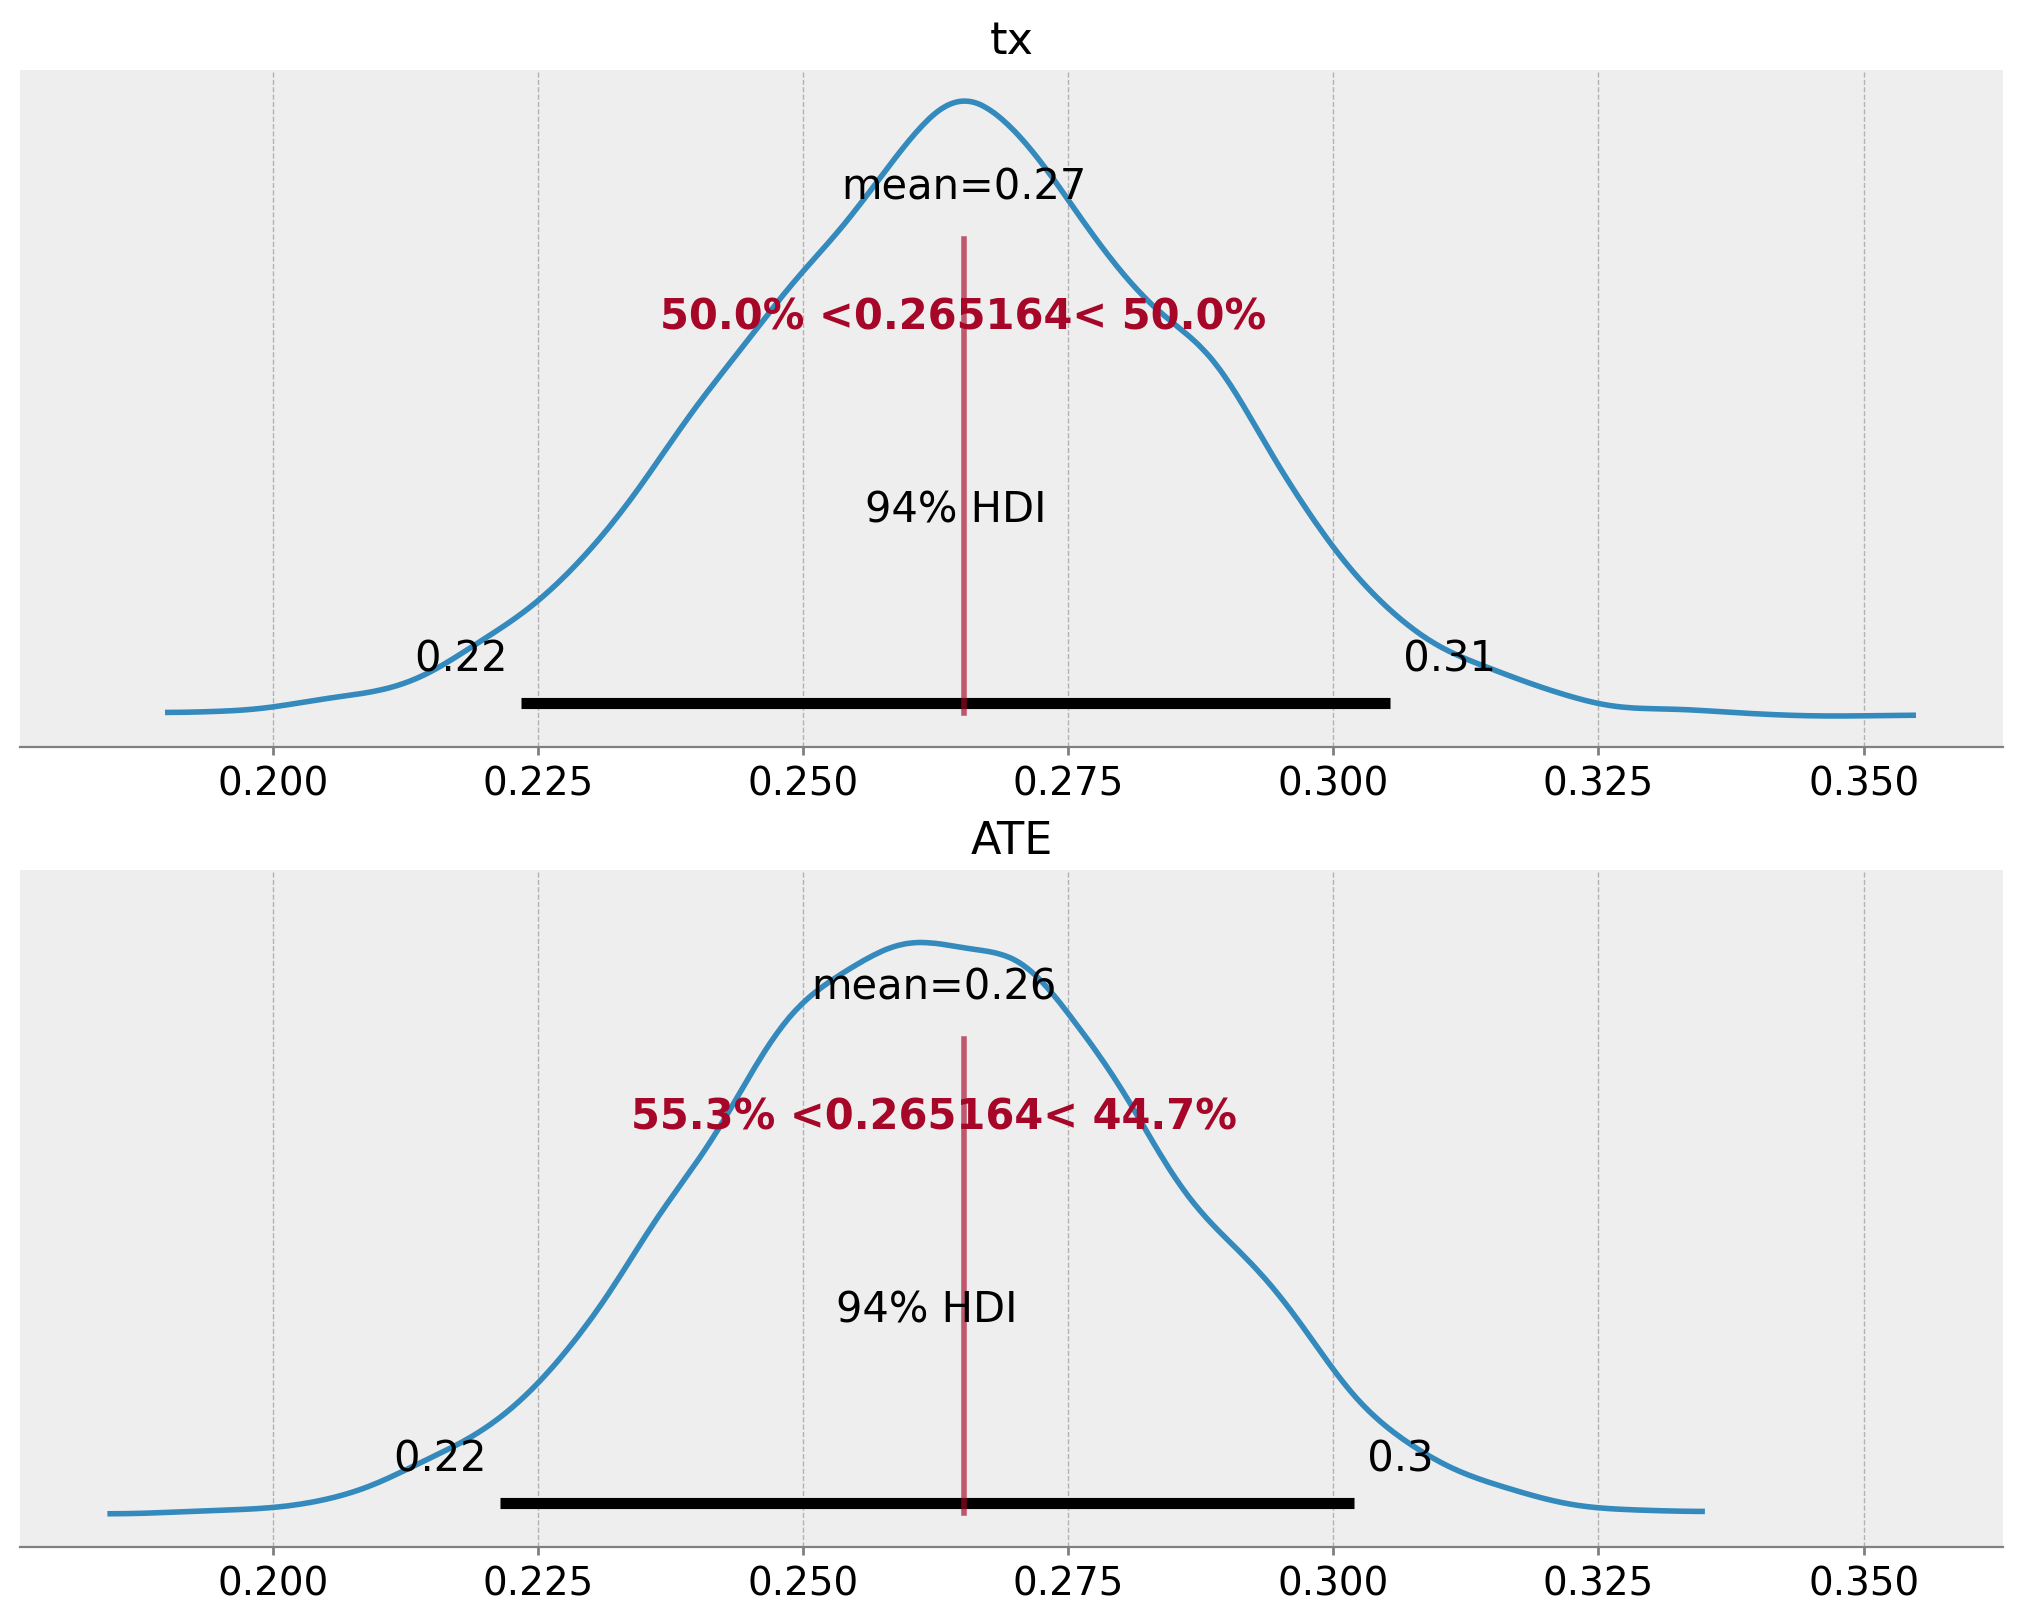

In [89]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=gaussian_idata, var_names=["tx"], ref_val=diff_means, ax=ax[0])
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax[1])
